In [1]:
cd ..

/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode


In [2]:
pwd

'/media/hjp/db6095ca-a560-4c3a-90ad-b667ec189671/REFERENCES/3D_VTO/GarmentCode/GarmentCode'

In [3]:
import os, sys
from glob import glob
import math
from pprint import pprint
import torch

import pygarment as pyg
import numpy as np
import matplotlib.pyplot as plt
import json
import svgpathtools
from svgpathtools import Path, Line
from matplotlib.colors import CenteredNorm
import time

import plotly.graph_objects as go
import trimesh
import pickle
from PIL import Image
import random
import cv2

from ANALYSIS.analysis_utils import *
     

In [4]:
render_props = {
    "resolution": [800, 800],
    "sides": ["front", "right", "back", "left"],
    "front_camera_location": [0, 0.97, 4.15],
    "uv_texture": {
        "seam_width": 0.5,
        "dpi": 1500,
        "fabric_grain_texture_path": "./assets/img/fabric_texture.png",
        "fabric_grain_resolution": 5
    }
}



In [5]:
PROJECT_ROOT_PATH = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/"
GARMENT_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "GarmentCodeData_v2")
BODY_ROOT_PATH = os.path.join(PROJECT_ROOT_PATH, "body_mesh")
MEAN_ALL_BODY_PATH = os.path.join(PROJECT_ROOT_PATH, "neutral_body/mean_all.obj")

default_body_mesh = trimesh.load(MEAN_ALL_BODY_PATH)

# BODY_TYPE = "random_body"
BODY_TYPE = "default_body"

garment_path_list = []
for path in  sorted(glob(os.path.join(GARMENT_ROOT_PATH, "*", BODY_TYPE, "*"))):
    if not os.path.isdir(path):
        continue
    dir_content = os.listdir(path)
    garmetn_id = os.path.basename(path)
    
    if (
        "combined_image_seam_info.json" in dir_content
    ) and (
        "combined_image_seam_info_1000_norm.json" in dir_content
    ) and (
        "combined_image.png" in dir_content
    ):
        garment_path_list.append(path)

In [6]:
len(garment_path_list)

78688

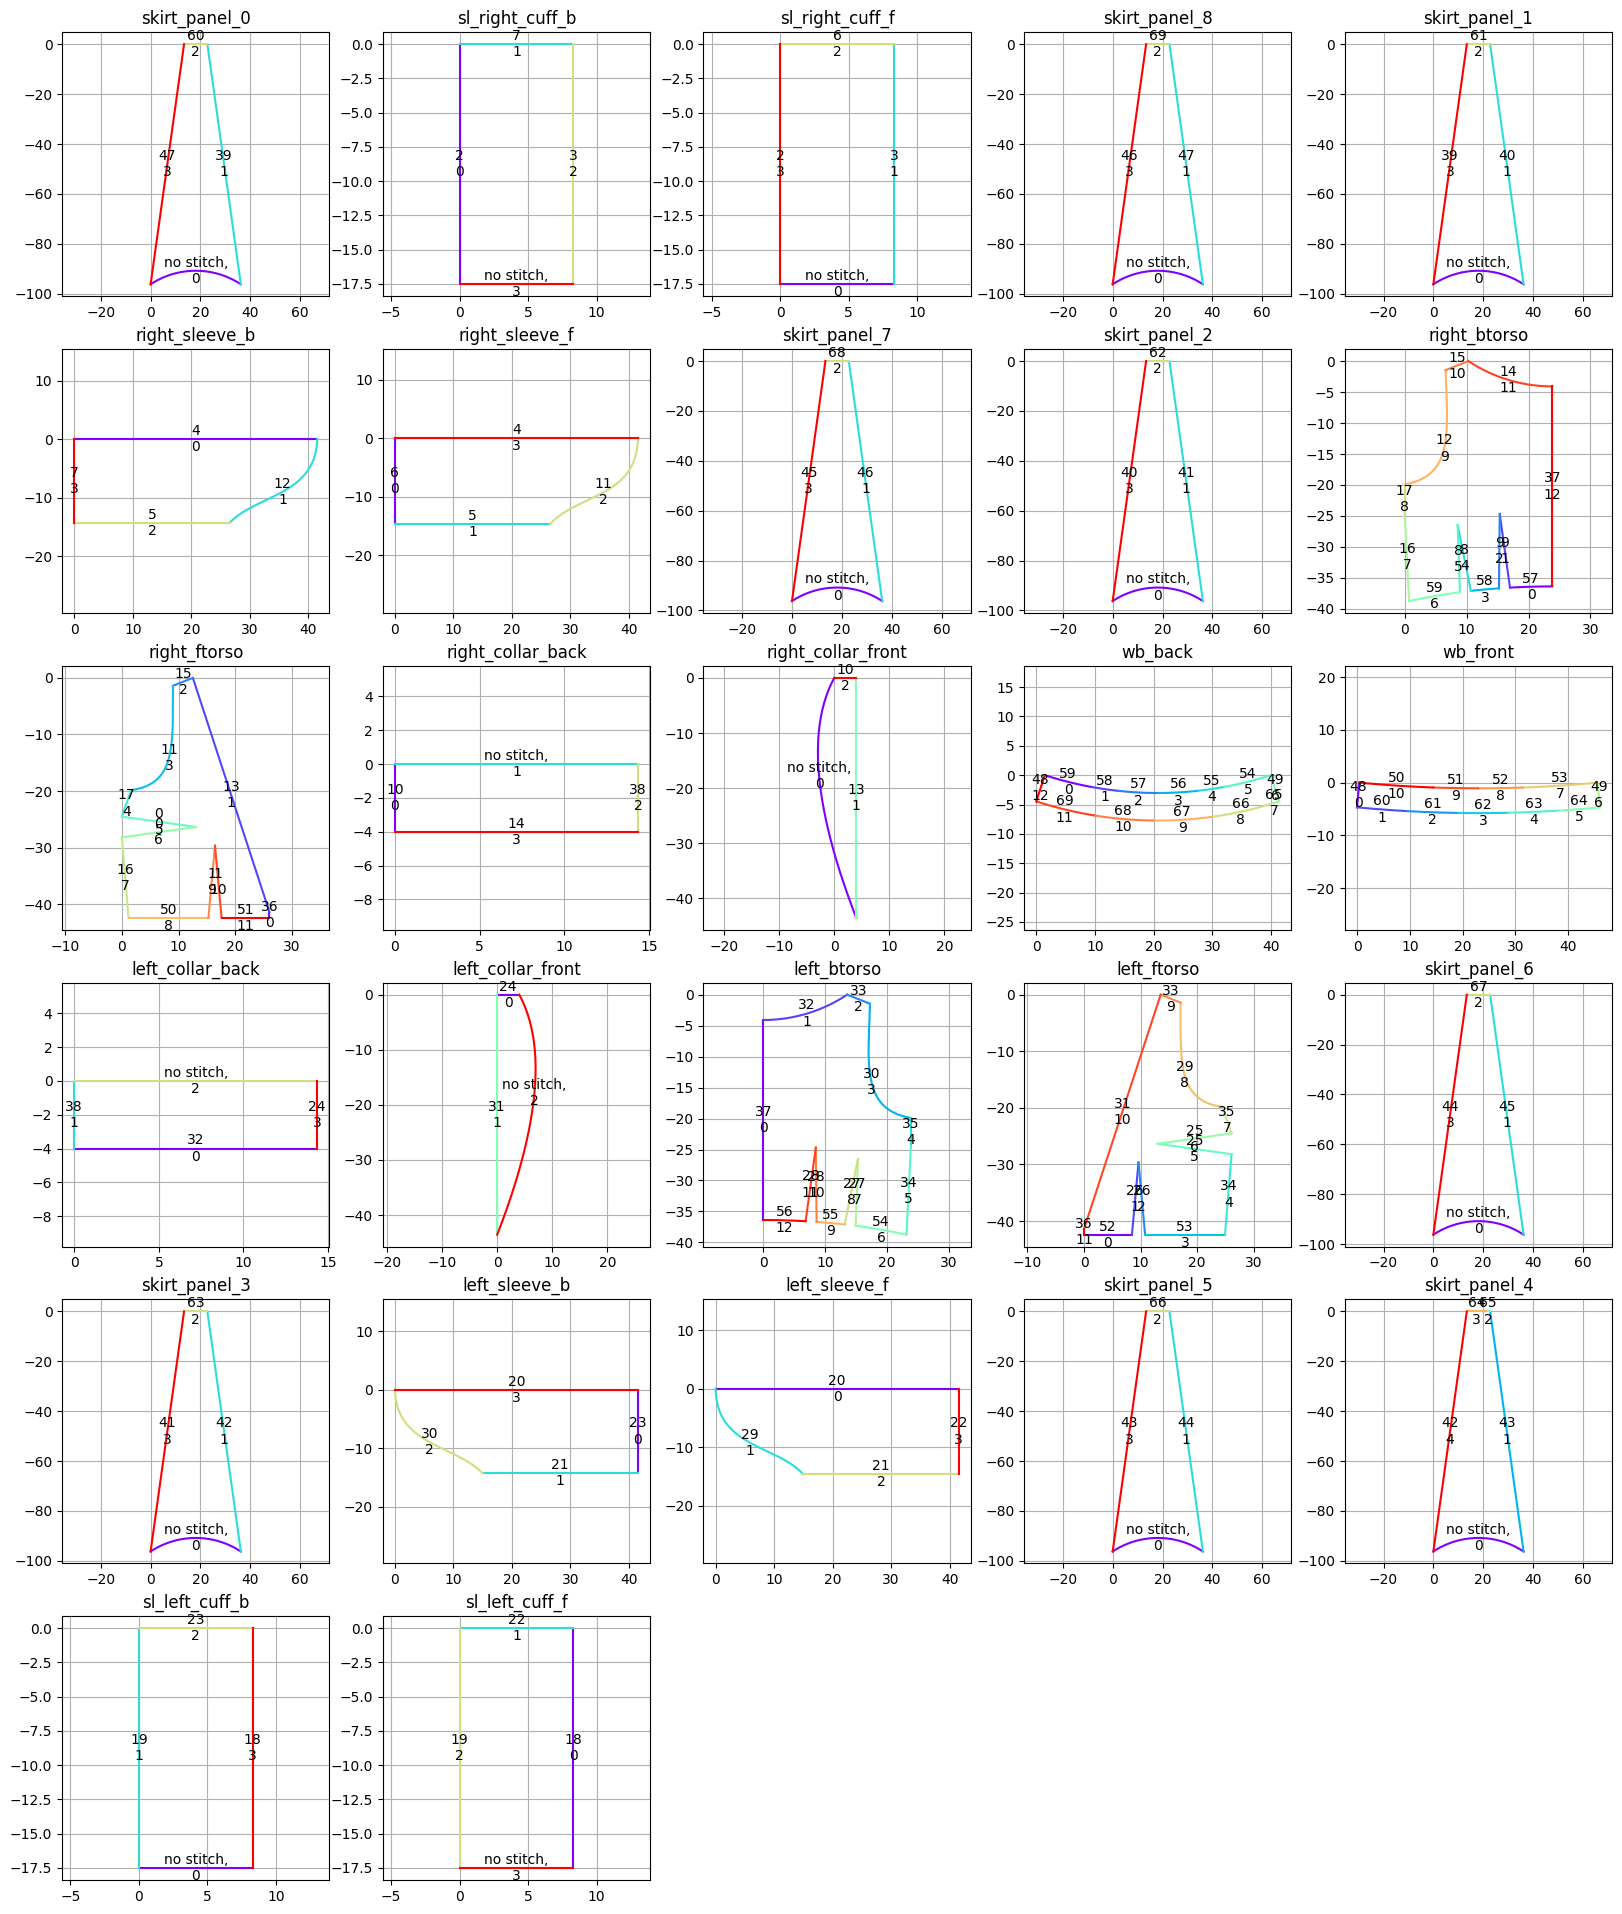

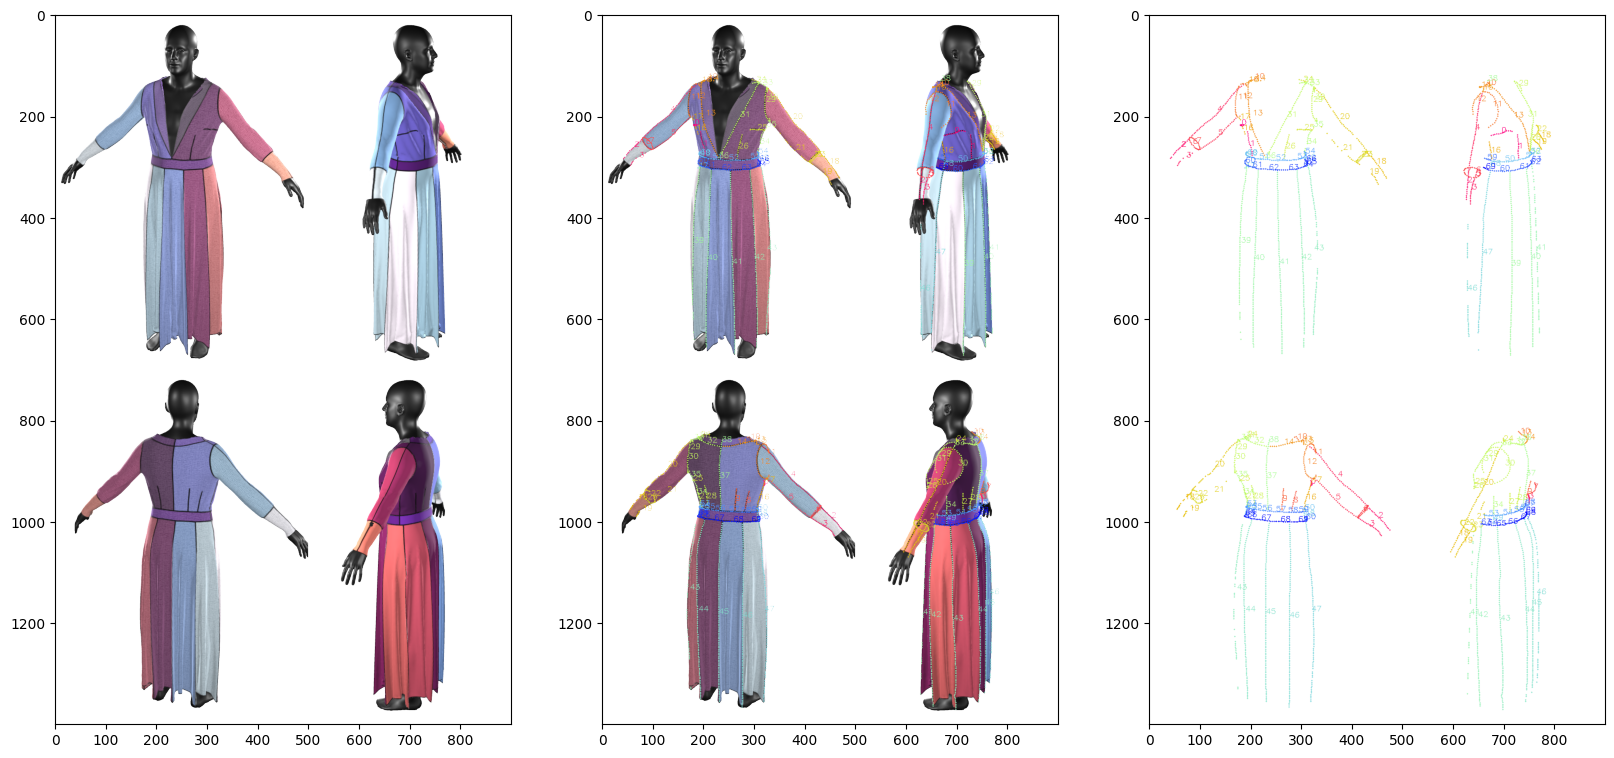

In [16]:
IDX = 3000

garment_path = garment_path_list[IDX]

garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0A36YXPNV0"
garment_path = "/media/hjp/05aba9a7-0e74-4e54-9bc9-5f11b9c4c757/GarmentCodeData/GarmentCodeData_v2/garments_5000_0/default_body/rand_0AAY3NQH8J"


garment_id = os.path.basename(garment_path)

SPEC_FILE_PATH = os.path.join(garment_path, f"{garment_id}_specification.json")
pattern = pyg.pattern.wrappers.VisPattern(SPEC_FILE_PATH)

panel_svg_path_dict = {
    panel_name : pattern._draw_a_panel(
        panel_name, apply_transform=False, fill=True
    )
    for panel_name in pattern.panel_order()
}
stitch_dict = {
    i : v for i, v in enumerate(pattern.pattern['stitches'])
}

rendered_image_list = list(map(
    lambda x : Image.open(os.path.join(garment_path, f"{garment_id}_render_{x}.png")),
    render_props["sides"]
))


with open(os.path.join(garment_path, "combined_image_seam_info.json"), "r") as f:
    combined_seam_dict = json.load(f)
with open(os.path.join(garment_path, "combined_image_seam_info_1000_norm.json"), "r") as f:
    combined_seam_dict_1000_norm = json.load(f)

final_image = Image.open(
    os.path.join(garment_path, "combined_image.png")
)
vis_image = Image.open(
    os.path.join(garment_path, "combined_image_with_seam.png")
)
vis_image_2 = Image.open(
    os.path.join(garment_path, "combined_image_seam_only.png")
)

FIGLEN = 4
NCOLS = int(np.sqrt(len(panel_svg_path_dict)))
NROWS = int(np.ceil(len(panel_svg_path_dict) / NCOLS))


plt.figure(figsize=(FIGLEN * NCOLS, FIGLEN * NROWS))
for i, (panel_name, panel) in enumerate(panel_svg_path_dict.items()):
    ax = plt.subplot(NROWS, NCOLS, i + 1)
    ax.set_title(panel_name)
    plot_panel_info(
        ax, panel_name, panel_svg_path_dict, stitch_dict,
        N_SAMPLES=1000
    )
plt.savefig(f"test_image_{IDX}.png", dpi=300, bbox_inches='tight')
plt.show()




plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(final_image)

plt.subplot(1, 3, 2)
plt.imshow(vis_image)

plt.subplot(1, 3, 3)
plt.imshow(vis_image_2)

plt.show()

In [8]:
count = 0
for panel_name, panel in pattern.pattern["panels"].items():
    
    # print(panel_name)
    # print(panel.keys())
    # print(len(panel["vertices"]))
    # print(len(panel["edges"]))
    # print()

    count += len(panel["edges"])
    
print(count * 2)

206


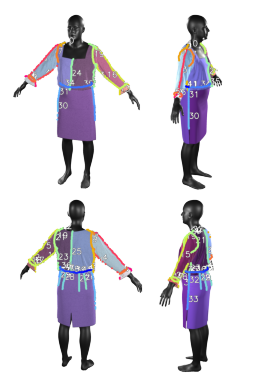

In [10]:
# Visualize combined_seam_dict

test_image_1 = np.array(final_image)

unique_stitch_indices = list(stitch_dict.keys())
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_stitch_indices)))
color_dict = dict(zip(unique_stitch_indices, colors))
unique_color_list = (colors[:, [2, 1, 0, 3]] * 255).astype(np.uint8) 


for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict[side].items():
        for vertex in vertices:
            cv2.circle(
                test_image_1,
                vertex,
                4, (255, 255, 255), -1
            )

test_image_2 = np.array(final_image)
height, width = test_image_2.shape[:2]
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_1000_norm[side].items():
        vertices_arr = np.array(vertices)
        cv2.putText(
            test_image_2,
            str(stitch_idx),
            org=(
                int(vertices_arr[:, 0].mean() / 1000 * width),
                int(vertices_arr[:, 1].mean() / 1000 * height)
            ),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(1, 1, 1),
            thickness=2
        )
        
        
        for vertex in vertices:
            cv2.circle(
                test_image_2,
                (
                    int(vertex[0] / 1000 * width),
                    int(vertex[1] / 1000 * height)
                ),
                4,
                unique_color_list[int(stitch_idx)].tolist(),
                -1
            )
        
        # for stt, end in zip(vertices[:-1], vertices[1:]):
        #     cv2.line(
        #         test_image_2,
        #         (
        #             int(stt[0] / 1000 * width),
        #             int(stt[1] / 1000 * height)
        #         ),
        #         (
        #             int(end[0] / 1000 * width),
        #             int(end[1] / 1000 * height)
        #         ),
        #         unique_color_list[int(stitch_idx)].tolist(),
        #         4
        #     )

# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.imshow(test_image_1)

# plt.subplot(1, 2, 2)
plt.imshow(test_image_2)
plt.axis("off")
plt.savefig(f"test_image_{IDX}.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
unique_color_list[0]

NameError: name 'unique_color_list' is not defined

# Annotate to Florence Input

In [11]:
count = 0
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_1000_norm[side].items():
        
        count += len(vertices)
print(count)


3715


/tmp/ipykernel_1096299/1607633484.py:27: RuntimeWarning: invalid value encountered in scalar divide
  cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


236


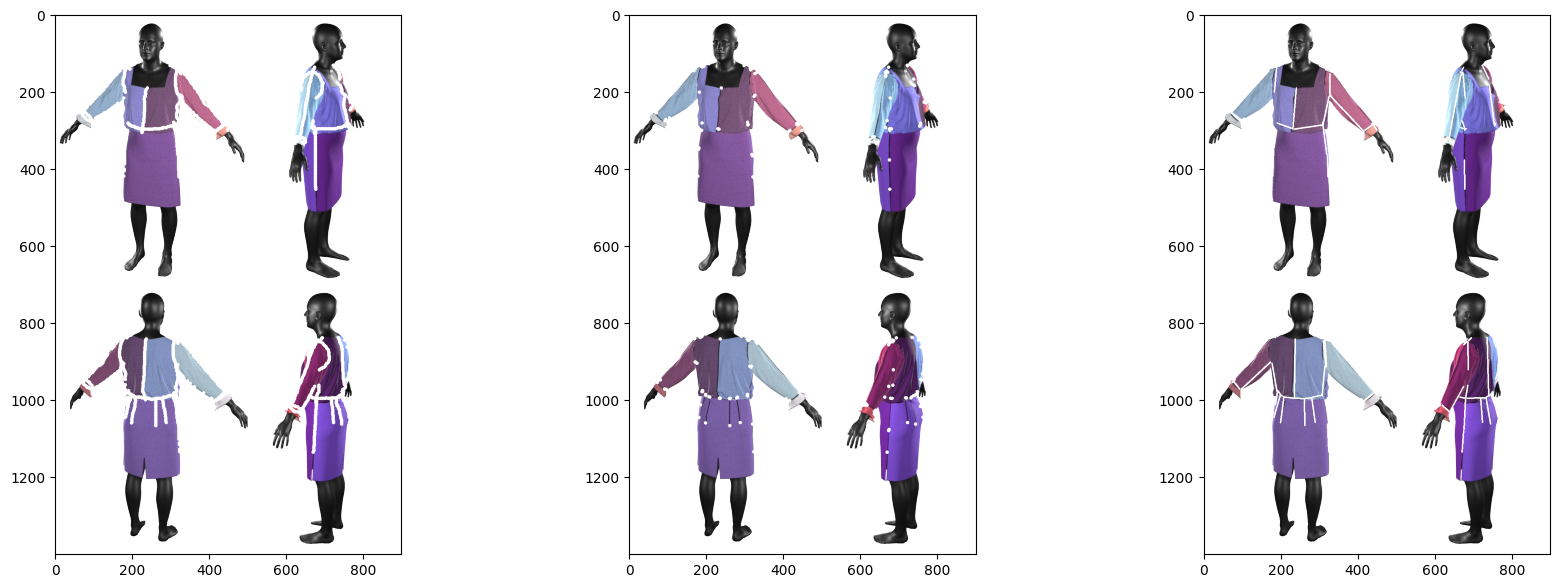

In [12]:
# We need to reduce the number of points


def adaptive_simplify_line(points, angle_threshold=5.0):
    """
    Simplifies a 2D point line adaptively based on curvature.

    Args:
        points: List of 2D points (N x 2 array).
        angle_threshold: Minimum angle (degrees) to retain a point in straight sections.

    Returns:
        Simplified list of points.
    """
    points = np.array(points)  # Convert to NumPy array
    simplified = [points[0]]  # Always keep the first point

    for i in range(1, len(points) - 1):
        # Get three consecutive points
        p1, p2, p3 = points[i - 1], points[i], points[i + 1]

        # Compute vectors
        v1 = p2 - p1
        v2 = p3 - p2

        # Calculate angle between vectors (in degrees)
        cosine_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        cosine_angle = np.clip(cosine_angle, -1.0, 1.0)  # Ensure numerical stability
        angle = np.degrees(np.arccos(cosine_angle))  # Convert to degrees

        # Retain point if angle exceeds threshold (curved region)
        if angle > angle_threshold:
            simplified.append(p2)

    simplified.append(points[-1])  # Always keep the last point
    return np.array(simplified)



combined_seam_dict_norm_trimed_dict = {}
for side, stitch_dict in combined_seam_dict_1000_norm.items():
    combined_seam_dict_norm_trimed_dict[side] = {}
    for stitch_idx, vertices in stitch_dict.items():
        combined_seam_dict_norm_trimed_dict[side][int(stitch_idx)] = adaptive_simplify_line(vertices, angle_threshold=5.0)
        
        
count = 0
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_norm_trimed_dict[side].items():
        count += len(vertices)
print(count)

test_image_1 = np.array(final_image)
height, width = test_image_1.shape[:2]
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_1000_norm[side].items():
        for vertex in vertices:
            cv2.circle(
                test_image_1,
                (
                    int(vertex[0] / 1000 * width),
                    int(vertex[1] / 1000 * height)
                ),
                4, (255, 255, 255), -1
            )

test_image_2 = np.array(final_image)
height, width = test_image_2.shape[:2]
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_norm_trimed_dict[side].items():
        for vertex in vertices:
            cv2.circle(
                test_image_2,
                (
                    int(vertex[0] / 1000 * width),
                    int(vertex[1] / 1000 * height)
                ),
                4, (255, 255, 255), -1
            )

test_image_3 = np.array(final_image)
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_norm_trimed_dict[side].items():
        if len(vertices) > 1 :
            for start, end in zip(vertices[:-1], vertices[1:]):
                cv2.line(
                    test_image_3,
                    (
                        int(start[0] / 1000 * width),
                        int(start[1] / 1000 * height)
                    ),
                    (
                        int(end[0] / 1000 * width),
                        int(end[1] / 1000 * height)
                    ),
                    (255, 255, 255),
                    2
                )

FIG_LEN = 7
NCOLS = 3
NROWS = 1
plt.figure(figsize=(FIG_LEN * NCOLS, FIG_LEN * NROWS))
plt.subplot(NROWS, NCOLS, 1)
plt.imshow(test_image_1)

plt.subplot(NROWS, NCOLS, 2)
plt.imshow(test_image_2)

plt.subplot(NROWS, NCOLS, 3)
plt.imshow(test_image_3)
plt.show()




594


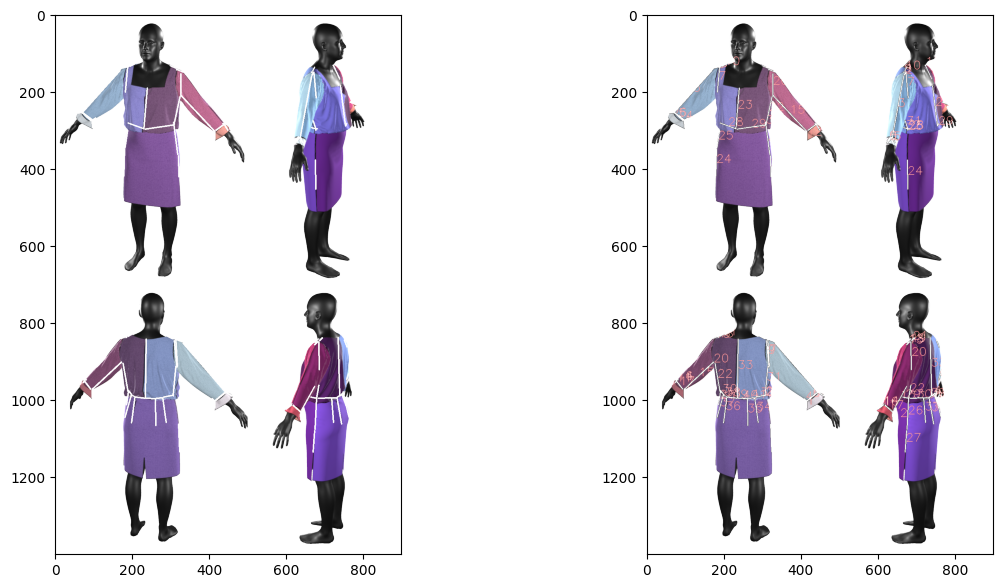

In [13]:
# Convert to Florence Token

stitch_idx_map = {}
florence_input_prototype = []
for idx, (side, stitch_dict) in enumerate(combined_seam_dict_norm_trimed_dict.items()):
    
    florence_input_prototype.append(f"<side_{idx}>")
    
    for stitch_idx, vertices in stitch_dict.items():
        if stitch_idx not in stitch_idx_map:
            stitch_idx_map[stitch_idx] = len(stitch_idx_map)
        florence_input_prototype.extend(
            [
                f"<stitch_{stitch_idx_map[stitch_idx]}>",
                *list(map(
                    lambda x : f"<loc_{x}>",
                    vertices.flatten()
                ))
            ]
        )
print(len(florence_input_prototype))


test_image_1 = np.array(final_image)
height, width = test_image_1.shape[:2]
for side in render_props["sides"]:
    for stitch_idx, vertices in combined_seam_dict_norm_trimed_dict[side].items():
        if len(vertices) > 1 :
            for start, end in zip(vertices[:-1], vertices[1:]):
                cv2.line(
                    test_image_1,
                    (
                        int(start[0] / 1000 * width),
                        int(start[1] / 1000 * height)
                    ),
                    (
                        int(end[0] / 1000 * width),
                        int(end[1] / 1000 * height)
                    ),
                    (255, 255, 255),
                    2
                )

test_image_2 = np.array(final_image)
height, width = test_image_2.shape[:2]

i = 0
cur_stitch = None
loc_list = []
while i < len(florence_input_prototype):
    
    if florence_input_prototype[i].startswith("<loc_"):
        loc_list.append(int(florence_input_prototype[i].replace("<loc_", "").replace(">", "")))
    
    else :
        if len(loc_list) > 0 :
            loc_list = np.array(loc_list).reshape(-1, 2)
            
            cv2.putText(
                test_image_2,
                str(cur_stitch.replace("<stitch_", "").replace(">", "")),
                org=(loc_list.mean(axis=0) / 1000 * np.array([width, height])).astype(np.int32),  
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 0, 0),
                thickness=1
            )
            
            for start, end in zip(loc_list[:-1], loc_list[1:]):    
                cv2.line(
                    test_image_2,
                    (
                        int(start[0] / 1000 * width),
                        int(start[1] / 1000 * height)
                    ),
                    (
                        int(end[0] / 1000 * width),
                        int(end[1] / 1000 * height)
                    ),
                    (0, 0, 0), 2)
                
            
            loc_list = []
            cur_stitch = None
            
        if florence_input_prototype[i].startswith("<side_"):
            pass
        elif florence_input_prototype[i].startswith("<stitch_"):
            cur_stitch = florence_input_prototype[i]
    i += 1
    
FIG_LEN = 7
NCOLS = 2
NROWS = 1
plt.figure(figsize=(FIG_LEN * NCOLS, FIG_LEN * NROWS))
plt.subplot(NROWS, NCOLS, 1)
plt.imshow(test_image_1)

plt.subplot(NROWS, NCOLS, 2)
plt.imshow(test_image_2)

plt.show()

In [15]:
print(len(florence_input_prototype))
print(florence_input_prototype)
print("".join(florence_input_prototype))
print()

594
['<side_0>', '<stitch_0>', '<loc_64>', '<loc_182>', '<loc_78>', '<loc_181>', '<stitch_1>', '<loc_107>', '<loc_195>', '<loc_108>', '<loc_209>', '<stitch_2>', '<loc_192>', '<loc_99>', '<loc_209>', '<loc_96>', '<stitch_3>', '<loc_78>', '<loc_181>', '<loc_187>', '<loc_103>', '<stitch_4>', '<loc_107>', '<loc_195>', '<loc_117>', '<loc_191>', '<stitch_5>', '<loc_78>', '<loc_181>', '<loc_104>', '<loc_196>', '<stitch_6>', '<loc_106>', '<loc_194>', '<loc_79>', '<loc_181>', '<stitch_7>', '<loc_209>', '<loc_96>', '<loc_203>', '<loc_143>', '<stitch_8>', '<loc_211>', '<loc_96>', '<loc_211>', '<loc_96>', '<stitch_9>', '<loc_211>', '<loc_96>', '<loc_212>', '<loc_96>', '<stitch_10>', '<loc_216>', '<loc_95>', '<loc_231>', '<loc_90>', '<stitch_11>', '<loc_488>', '<loc_203>', '<loc_498>', '<loc_214>', '<stitch_12>', '<loc_461>', '<loc_231>', '<loc_461>', '<loc_216>', '<stitch_13>', '<loc_352>', '<loc_101>', '<loc_369>', '<loc_106>', '<stitch_14>', '<loc_488>', '<loc_203>', '<loc_484>', '<loc_201>', '<